# Feature Importance

## TO-DOs
- Add interpretation of rf importances plotted

## Lesson Objectives

By the end of this lesson, students will be able to:
- Explain what feature importance is, which models use it, and what it means.
- Visualize and construct recommendations using feature importance.
- Implement scikit-learn's permutation_importance, and its advantages over built-in importance.

# Previously....

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


## Reviewing the options used
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

## Customization Options
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import joblib

SEED = 321
np.random.seed(SEED)

## Code/Model From Previous Lesson

In [2]:
## Load in the King's County housing dataset and display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    float64
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.00,U,GT3,A,4.00,4.00,at_home,teacher,course,mother,2.00,2.00,0.00,yes,no,no,no,yes,yes,no,no,4.00,3.00,4.00,1.00,1.00,3.00,6.00,5.00,6.00,6.00
1,GP,F,17.00,U,GT3,T,1.00,1.00,at_home,other,course,father,1.00,2.00,0.00,no,yes,no,no,no,yes,yes,no,5.00,3.00,3.00,1.00,1.00,3.00,4.00,5.00,5.00,6.00
2,GP,F,15.00,U,LE3,T,1.00,1.00,at_home,other,other,mother,1.00,2.00,3.00,yes,no,yes,no,yes,yes,yes,no,4.00,3.00,2.00,2.00,3.00,3.00,10.00,7.00,8.00,10.00
3,GP,F,15.00,U,GT3,T,4.00,2.00,health,services,home,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,yes,yes,yes,3.00,2.00,2.00,1.00,1.00,5.00,2.00,15.00,14.00,15.00
4,GP,F,16.00,U,GT3,T,3.00,3.00,other,other,home,father,1.00,2.00,0.00,no,yes,yes,no,yes,yes,no,no,4.00,3.00,2.00,1.00,2.00,5.00,4.00,6.00,10.00,10.00


In [3]:
# ### Train Test Split
## Make x and y variables
y = df['G3'].copy()
X = df.drop(columns=['G3']).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.00,1.00,2.00,1.00,2.00,0.00,4.00,3.00,2.00,1.00,1.00,5.00,2.00,9.00,10.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
338,18.00,3.00,3.00,1.00,4.00,0.00,5.00,3.00,3.00,1.00,1.00,1.00,7.00,16.00,15.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
291,17.00,4.00,3.00,1.00,3.00,0.00,4.00,2.00,2.00,1.00,2.00,3.00,0.00,15.00,15.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00


In [4]:
def evaluate_linreg(model, X_train,y_train, X_test,y_test, get_coeffs=True):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    results = []
    y_hat_train = model.predict(X_train)
    r2_train = r2_score(y_train,y_hat_train)
    rmse_train = mean_squared_error(y_train,y_hat_train, squared=False)
    results.append({'Data':'Train', 'R^2':r2_train, "RMSE": rmse_train})
    
    y_hat_test = model.predict(X_test)
    r2_test = r2_score(y_test,y_hat_test)
    rmse_test = mean_squared_error(y_test,y_hat_test, squared=False)
    results.append({'Data':'Test', 'R^2':r2_test, "RMSE": rmse_test})
    
    results_df = pd.DataFrame(results).round(3).set_index('Data')
    results_df.loc['Delta'] = results_df.loc['Test'] - results_df.loc['Train']
    results_df = results_df.T
    results_df.index.name=None
    print(results_df)
                    
    if get_coeffs:
        try:
            coeffs = pd.Series(model.coef_, index= X_train.columns)
            coeffs.loc['intercept'] = model.intercept_
            return coeffs
        except:
            print('[!] Could not extract coefficients from model.')


## "Best" Model From Previous Lesson

### Modeling with Ordinal Zipcodes

- We will need to remake our X,y, X_train,y_train, etc.
- We will also want to make a copy of our preprocessor so we can leave the original one intact with the values it learned from the earlier X/y data.

In [5]:
## fitting a linear regression model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_df, y_train)
coeffs_orig = evaluate_linreg(lin_reg, X_train_df, y_train, X_test_df,y_test)
coeffs_orig 

Data  Train  Test  Delta
R^2    0.85  0.81  -0.04
RMSE   1.83  1.85   0.02


age                 -0.22
Medu                 0.29
Fedu                -0.18
traveltime           0.19
studytime           -0.22
failures            -0.10
famrel               0.31
freetime             0.02
goout               -0.02
Dalc                -0.21
Walc                 0.26
health               0.03
absences             0.05
G1                   0.14
G2                   0.99
school_MS            0.38
sex_M               -0.01
address_U            0.15
famsize_LE3          0.01
Pstatus_T            0.38
Mjob_at_home        -0.05
Mjob_health         -0.02
Mjob_other           0.16
Mjob_services        0.12
Mjob_teacher        -0.21
Fjob_at_home         0.33
Fjob_health          0.38
Fjob_other          -0.11
Fjob_services       -0.54
Fjob_teacher        -0.05
reason_course       -0.09
reason_home         -0.42
reason_other         0.30
reason_reputation    0.21
guardian_father     -0.20
guardian_mother      0.07
guardian_other       0.13
schoolsup_yes        0.34
famsup_yes  

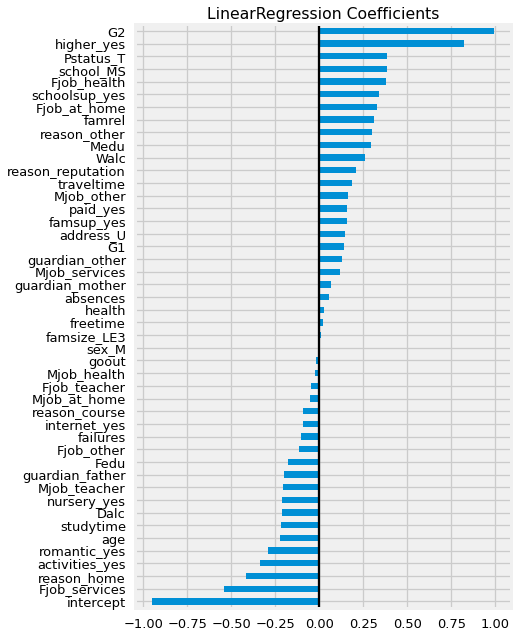

In [6]:

ax = coeffs_orig.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

## Tree Based Models - Feature Importance

- There are many models that do not use/calculate coefficients as part of the modeling process. 
- Tree-Based models (decision trees, random forests, xgboost, etc) use/calculate feature importance.

- According to the [Scikit-Learn RandomForest Documentation on Feature Importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier.feature_importances_) "**Feature Importance**"is:
    - "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."
        - In other words, its how helpful each feature was in growing/sorting the tree-based model. The more helpful a feature was in separating the data. The more "important" it is. 
        
        

In [7]:
## fit random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_linreg(rf_reg,X_train_df,y_train,X_test_df,y_test)

Data  Train  Test  Delta
R^2    0.98  0.91  -0.07
RMSE   0.66  1.24   0.58
[!] Could not extract coefficients from model.


In [8]:
# get importance
def get_importance(model, feature_names):
    df_importance = pd.Series(model.feature_importances_,
                              index=feature_names)
    return df_importance.sort_values(ascending=False)

importances = get_importance(rf_reg, feature_names)
importances

G2                  0.77
absences            0.12
age                 0.02
studytime           0.01
health              0.01
G1                  0.01
famrel              0.01
schoolsup_yes       0.01
Medu                0.00
reason_home         0.00
activities_yes      0.00
Fedu                0.00
Walc                0.00
goout               0.00
reason_reputation   0.00
school_MS           0.00
failures            0.00
freetime            0.00
traveltime          0.00
paid_yes            0.00
guardian_mother     0.00
reason_course       0.00
Fjob_services       0.00
famsize_LE3         0.00
Mjob_teacher        0.00
Fjob_other          0.00
Mjob_services       0.00
sex_M               0.00
Mjob_other          0.00
internet_yes        0.00
nursery_yes         0.00
romantic_yes        0.00
guardian_father     0.00
Fjob_health         0.00
famsup_yes          0.00
Dalc                0.00
Mjob_at_home        0.00
higher_yes          0.00
guardian_other      0.00
Fjob_at_home        0.00


### Interpreting Feature Importance

<AxesSubplot:>

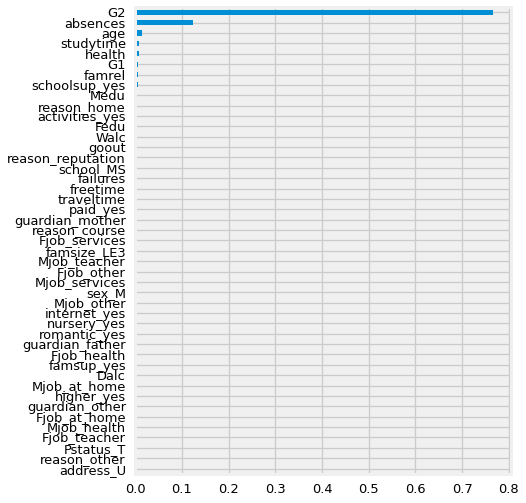

In [9]:
# plot importance
importances.sort_values().plot(kind='barh',figsize=(6,8))

- **What the feature importances tell us:**
    - G2 is by far the single most important feature for predicting G3.
    - The # of absences is the second most important.
    - Everything is relatively unimportant. 
    
- **What the feature importances don't tell us:**
    - Notice that all of the values on the graph are positive.
        - There is no +/- directionality with feature importance!
    - We only know that a feature was heavily used to predict the target, but we DON'T KNOW the actual **relationship** between the feature and target.
    - Does having a higher G2 mean higher G3?
    - Does more absences mean a higher G3?
    > We don't know!

        
- **Additional Considerations/Caveats for Feature Importance**

    - Also from the [Scikit-Learn RandomForest Documentation on Feature Importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier.feature_importances_):
    
    - " Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative."
    - In other words, model-based feature importance is biased towards valuing features with many values (

## Modeling without Confounding/Inappropriate Features Features

- If we weren't sure that we should remove G1 and G2 before, look at how much G2 is DOMINATING the feature importance. We can hardly see the other features.
    - Considering the business case considerations we discussed previously, this really confirms that including G2 is not going to help us get a better understanding of which students perform better in year 3 and why.

In [10]:
## Drop the G1 and G2 features from the x vars
X_train_df = X_train_df.drop(columns=['G1','G2'])
X_test_df = X_test_df.drop(columns=['G1','G2'])
X_train_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
215,17.00,3.00,2.00,2.00,2.00,0.00,4.00,4.00,4.00,1.00,3.00,1.00,2.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00
48,15.00,4.00,2.00,1.00,2.00,0.00,4.00,3.00,3.00,2.00,2.00,5.00,2.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00
303,17.00,3.00,2.00,1.00,4.00,0.00,5.00,2.00,2.00,1.00,2.00,5.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00
160,17.00,2.00,1.00,2.00,1.00,2.00,3.00,3.00,2.00,2.00,2.00,5.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00
60,16.00,4.00,4.00,1.00,2.00,0.00,2.00,4.00,4.00,2.00,3.00,4.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,16.00,4.00,3.00,1.00,2.00,0.00,4.00,3.00,5.00,1.00,5.00,2.00,2.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
297,18.00,4.00,3.00,2.00,2.00,0.00,4.00,4.00,5.00,1.00,2.00,2.00,10.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00
287,17.00,1.00,1.00,1.00,3.00,0.00,4.00,3.00,3.00,1.00,1.00,3.00,6.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00
124,16.00,2.00,2.00,1.00,2.00,0.00,5.00,4.00,4.00,1.00,1.00,5.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00


In [11]:
def evaluate_regression(model, X_train,y_train, X_test,y_test, get_params=True,
                       sort_params=True,ascending=True):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    results = []
    y_hat_train = model.predict(X_train)
    r2_train = r2_score(y_train,y_hat_train)
    rmse_train = mean_squared_error(y_train,y_hat_train, squared=False)
    results.append({'Data':'Train', 'R^2':r2_train, "RMSE": rmse_train})
    
    y_hat_test = model.predict(X_test)
    r2_test = r2_score(y_test,y_hat_test)
    rmse_test = mean_squared_error(y_test,y_hat_test, squared=False)
    results.append({'Data':'Test', 'R^2':r2_test, "RMSE": rmse_test})
    
    results_df = pd.DataFrame(results).round(3).set_index('Data')
    results_df.loc['Delta'] = results_df.loc['Test'] - results_df.loc['Train']
    results_df = results_df.T
#     results_df.index.name=None
    print(results_df)
                    
    if get_params:
        ## if a regression with coef_
        if hasattr(model, 'coef_'):
            params = pd.Series(model.coef_, index= X_train.columns,
                              name='Coefficients')
            params.loc['intercept'] = model.intercept_

        ## if a tree model with feature importance
        elif hasattr(model, 'feature_importances_'):
            params = pd.Series(model.feature_importances_,
                              index=X_train.columns, name='Feature Importance')
            
        else:
            print('[!] Could not extract coefficients or feature importances from model.')
    if sort_params:
        return params.sort_values(ascending=ascending)
    else:
        return params

Data  Train  Test  Delta
R^2    0.91  0.13  -0.77
RMSE   1.44  3.92   2.48


<AxesSubplot:>

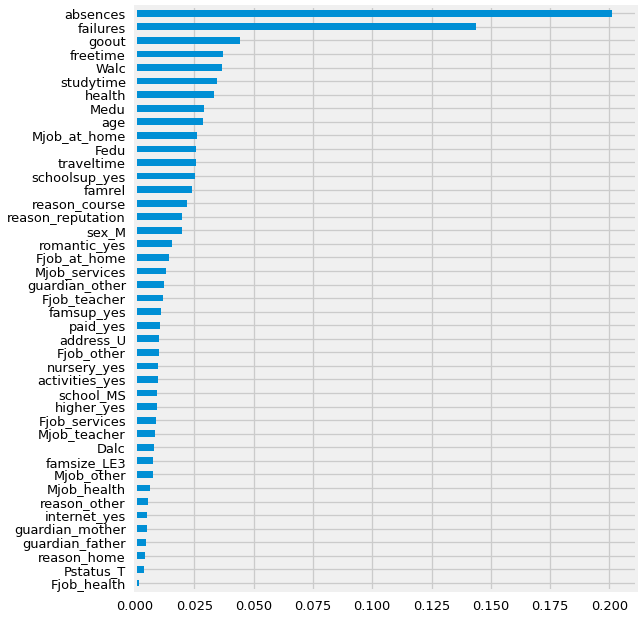

In [12]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
importances = evaluate_regression(rf_reg,X_train_df,y_train,X_test_df,y_test)
importances.plot(kind='barh',figsize=(8,10))

### Interpreting Feature Importance

- TO DO: Interpret

### Beyond Built-In Importances

- Scikit-learn has a tool called [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance) that will calculate feature importance, without the issues discussed above. 

- The function will take our model and our features and it will repeat the modeling for each feature.
    - One at a time, for each feature, it will shuffle all of the rows JUST IN THAT ONE FEATURE and repeat the modeling process.
    - The idea is that we are scrambling/destroying that features relationship to our target.

- Then, it examines which feature caused the biggest decrease in the model's performance, and it uses this information to determine the "permutation importance"



In [13]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(rf_reg, X_train_df, y_train,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [14]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
permutation_importances

age                 0.03
Medu                0.05
Fedu                0.03
traveltime          0.02
studytime           0.04
failures            0.41
famrel              0.02
freetime            0.04
goout               0.06
Dalc                0.01
Walc                0.05
health              0.04
absences            0.53
school_MS           0.01
sex_M               0.06
address_U           0.01
famsize_LE3         0.01
Pstatus_T           0.00
Mjob_at_home        0.05
Mjob_health         0.01
Mjob_other          0.01
Mjob_services       0.02
Mjob_teacher        0.01
Fjob_at_home        0.02
Fjob_health         0.00
Fjob_other          0.01
Fjob_services       0.01
Fjob_teacher        0.01
reason_course       0.07
reason_home         0.00
reason_other        0.01
reason_reputation   0.02
guardian_father     0.00
guardian_mother     0.00
guardian_other      0.01
schoolsup_yes       0.04
famsup_yes          0.02
paid_yes            0.01
activities_yes      0.01
nursery_yes         0.01


<AxesSubplot:>

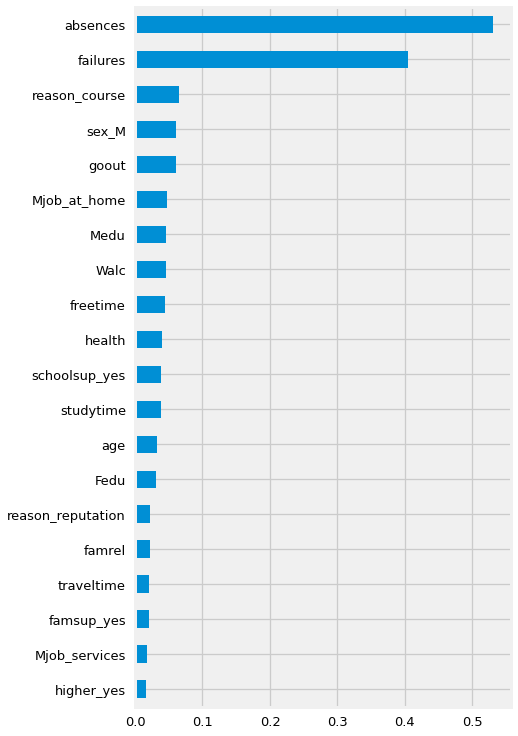

In [15]:
permutation_importances.sort_values().tail(20).plot(kind='barh',figsize=(6,12))

- According to the permutation importance results:
    - Zipcode, sqft_living,and grade were the most important features in predicting price. 
    


### Permutation Importance vs Feature Importance

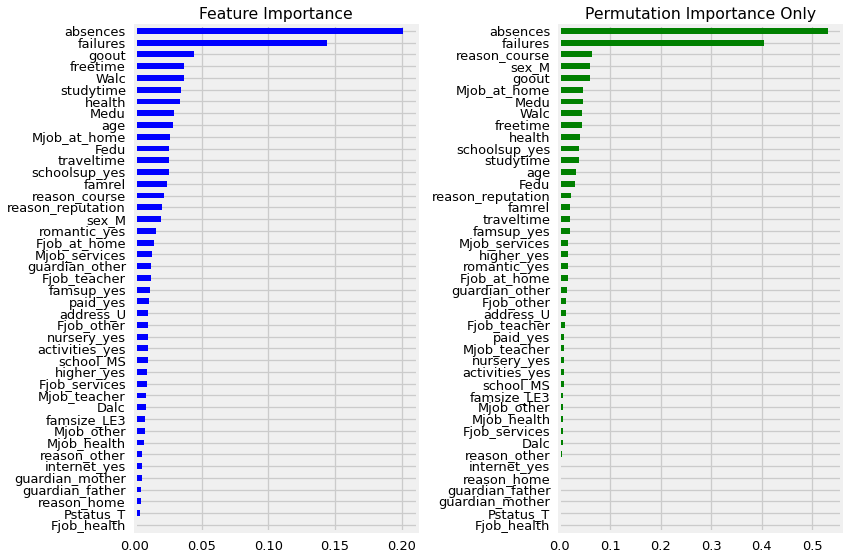

In [16]:
fig, axes = plt.subplots(ncols=2,figsize=(12,8))

importances.sort_values().plot(kind='barh',color='blue',ax=axes[0],title='Feature Importance')
permutation_importances.sort_values().plot(kind='barh',color='green',ax=axes[1],title='Permutation Importance Only')
fig.tight_layout()

- When compared side by side, we can see that the permutation importances and feature importances were similar, but not exactly the same.
- Both importances had the same top 3 most important features, although in a different order.
    - Importantly the feature that the random forest considered to be the most important feature, grade, had a much lower permutation importance when compared to the the most important feature.

### Permutation Importance is Model-Agnostic

- Permutation Importance can be calculated using any sklearn model, not just tree-based models.


In [17]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_df, y_train)
coeffs_orig = evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)
coeffs_orig 

Data  Train  Test  Delta
R^2    0.30  0.04  -0.26
RMSE   3.91  4.12   0.21


failures            -1.79
Mjob_teacher        -1.63
romantic_yes        -1.39
schoolsup_yes       -1.08
famsup_yes          -1.07
reason_course       -0.99
Fjob_other          -0.82
goout               -0.70
Fjob_services       -0.65
guardian_father     -0.65
age                 -0.34
Dalc                -0.33
Mjob_other          -0.31
Mjob_at_home        -0.30
reason_home         -0.21
health              -0.21
guardian_mother     -0.20
nursery_yes         -0.13
traveltime          -0.13
Pstatus_T           -0.12
Fedu                -0.06
absences             0.05
activities_yes       0.06
famrel               0.12
Fjob_at_home         0.17
freetime             0.27
famsize_LE3          0.29
studytime            0.29
Fjob_health          0.29
Walc                 0.36
paid_yes             0.41
reason_reputation    0.45
Mjob_services        0.54
Medu                 0.58
address_U            0.60
school_MS            0.61
reason_other         0.75
internet_yes         0.76
guardian_oth

<AxesSubplot:>

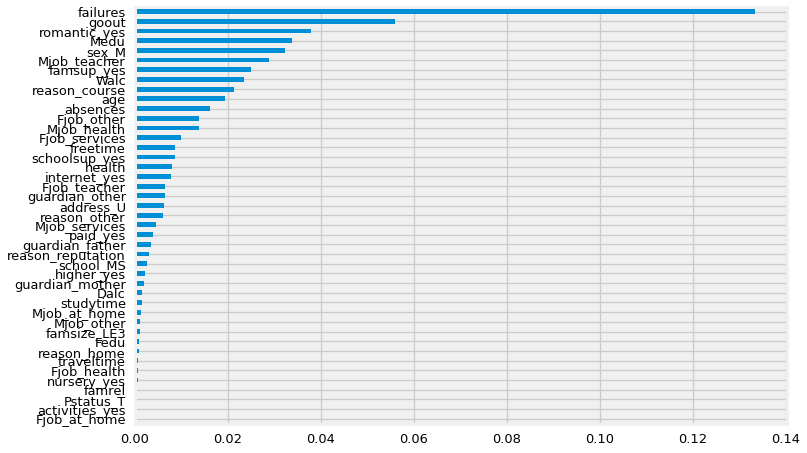

In [18]:
## Permutation importance takes a fit mode and test data. 

r = permutation_importance(lin_reg, X_train_df, y_train,n_repeats =5)

## can make the mean importances into a series
permutation_importances_linreg = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
permutation_importances_linreg.sort_values().plot(kind='barh')

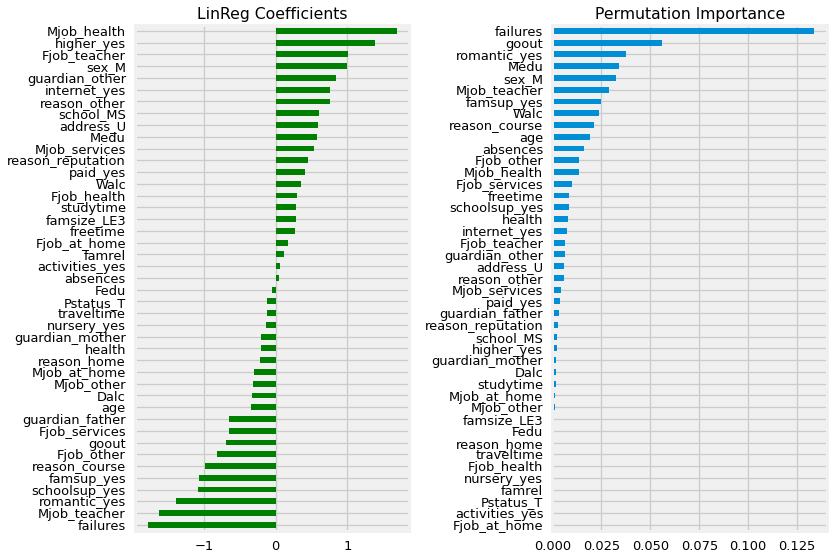

In [19]:
fig, axes = plt.subplots(ncols=2,figsize=(12,8))

coeffs_orig.drop('intercept').sort_values().plot(kind='barh',color='green',ax=axes[0],
                                       title='LinReg Coefficients')

permutation_importances_linreg.sort_values().plot(kind='barh',ax=axes[1],
                                                 title='Permutation Importance')

fig.tight_layout()

- Notice how different the sorted coefficients are from the sorted feature importances.
- Since some coefficients are negative, we should try sorting them by their size alone using the absolute value and compare them to the related permutation importance.

In [20]:
## Making 1 dataframe combining lin reg coeffs and permutation importance
df_compare = pd.DataFrame({"LinReg Coeffs":coeffs_orig.drop('intercept'),
                          'Permutation Importance':permutation_importances_linreg,
                          }, index=coeffs_orig.drop('intercept').index)

##  Calculate the rank of the coefficients (according to their abs value)
df_compare['Coeff Rank'] = df_compare['LinReg Coeffs'].abs().rank()

## Sort by rank 
df_compare = df_compare.sort_values('Coeff Rank')
df_compare

,LinReg Coeffs,Permutation Importance,Coeff Rank
absences,0.05,0.02,1.00
Fedu,-0.06,0.00,2.00
activities_yes,0.06,0.00,3.00
famrel,0.12,0.00,4.00
Pstatus_T,-0.12,0.00,5.00
traveltime,-0.13,0.00,6.00
nursery_yes,-0.13,0.00,7.00
Fjob_at_home,0.17,0.00,8.00
guardian_mother,-0.20,0.00,9.00
health,-0.21,0.01,10.00


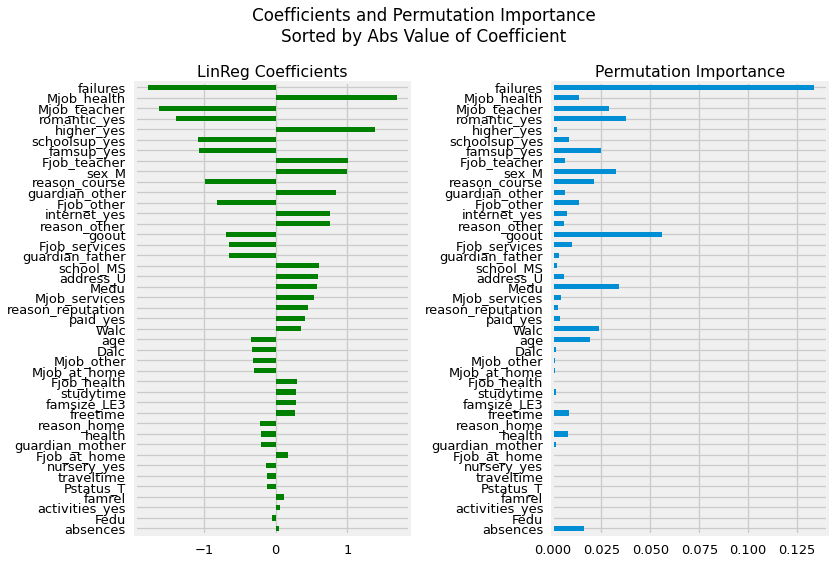

In [21]:
## visually compare the coefficients and importances (same order)
fig, axes = plt.subplots(ncols=2,figsize=(12,8))

df_compare['LinReg Coeffs'].plot(kind='barh',color='green',ax=axes[0],
                                       title='LinReg Coefficients')

df_compare['Permutation Importance'].plot(kind='barh',ax=axes[1],
                                                 title='Permutation Importance')
fig.suptitle('Coefficients and Permutation Importance\nSorted by Abs Value of Coefficient')
fig.tight_layout()

> `Add example interpretation for stakeholder?`

## Advantages/Disadvantages of Permutation Importance

- Advantages:
    - Model agnostic (can be used on any model)
    - Avoids the biases of built-in feature importances.
- Disadvantages:
    - Only positive values (don't know which way each feature pushes the model's predictions)

## Beyond sklearn

- Next lesson, we will introduce additional packages designed to explain machine learning models with greater detail. 


### Summary
- In this lesson we learned about feature importance and its advantages and disadvangates. We also implemented a scikit-learn tool that calculated similar importances, but in a more fair/thoughtful way. 

- Next lesson, we will introduce some additional packages whose entire purpose is to better explain how models make their predictions. 

# APPENDIX

## Saving the Model

In [22]:
## saving variables for next lesson/notebook
import joblib

export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df, 
         "y_test": y_test,
         'preprocessor':preprocessor,
         'lin_reg':lin_reg,
         'rf_reg':rf_reg}

joblib.dump(export, 'lesson_03.joblib')

['lesson_03.joblib']